In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from collections import Counter
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.ndimage import shift
from scipy.signal import fftconvolve
from numpy.linalg import norm
from tqdm import tqdm
from scipy.optimize import curve_fit
import pickle
import sys
sys.path.append('../lib')
from detection_methods import compare_trajectory_method, plt_accuracy_results, trajectory_till, trajectory_till_stepwise, trajectory_gauss, plt_accuracy_results, make_test_trajectory, trajectory_polar_comparison,save_result, compare_trajectories, fit_gaussian
from fast_detection_methods import trajectory_mean, trajectory_corr, trajectory_gauss
import os
from movie_processing import movie_to_array,clean_problem_pixels

    

In [2]:
def select_file(khz_value, files):
    for file in files:
        if f"{khz_value}_khz" in file:
            return file
    return None

data_path = r'\\134.76.13.158\betzlab\Julian\Hydrogel\measurement_2'

file_list =[ file for file in  os.listdir(data_path) if file.endswith('.avi')]
file = select_file(1, file_list)
file_path = os.path.join(data_path, file)
numpy_movie = movie_to_array(file_path, max_frames=10)
numpy_movie = clean_problem_pixels(numpy_movie)
image = numpy_movie[0]

Processing video: 100%|██████████| 10/10 [00:00<00:00, 9892.23frame/s]


In [9]:
image.sum(axis=0)

array([ 273,  226,  249,  245,  254,  278,  269,  254,  257,  263,  258,
        252,  254,  244,  260,  263,  256,  231,  258,  262,  285,  237,
        230,  276,  251,  253,  251,  209,  255,  252,  247,  256,  242,
        228,  257,  279,  318,  362,  531,  626,  756,  953, 1172, 1482,
       1741, 2026, 2333, 2665, 2828, 3136, 3311, 3535, 3627, 3738, 3841,
       3925, 4076, 4097, 4120, 4143, 4295, 4306, 4468, 4535, 4681, 4771,
       4958, 5008, 5020, 4991, 4875, 4840, 4652, 4363, 3997, 3701, 3256,
       2843, 2418, 2063, 1707, 1406, 1143,  905,  754,  624,  564,  404,
        361,  279,  261,  259,  256,  237,  237,  247,  290,  232,  241,
        226,  225,  236,  246,  233,  264,  248,  265,  243,  257,  243,
        248,  223,  247,  238,  237,  237,  248,  264,  230,  241,  238,
        220,  251,  251,  256,  229,  239,  233])

In [10]:
image.sum(axis=1)

array([ 274,  618,  277,  593,  299,  609,  281,  616,  289,  596,  285,
        643,  374,  733,  586,  994,  915, 1388, 1425, 1989, 2143, 2748,
       2954, 3456, 3622, 4129, 4196, 4523, 4468, 4623, 4469, 4506, 4280,
       4322, 4026, 4138, 3888, 3956, 3774, 3907, 3842, 4021, 4014, 4259,
       4229, 4506, 4472, 4529, 4369, 4473, 4124, 4013, 3583, 3409, 2857,
       2631, 2112, 1968, 1480, 1476,  998, 1050,  668,  833,  446,  670,
        319,  579,  287,  612,  270,  553,   59,  297])

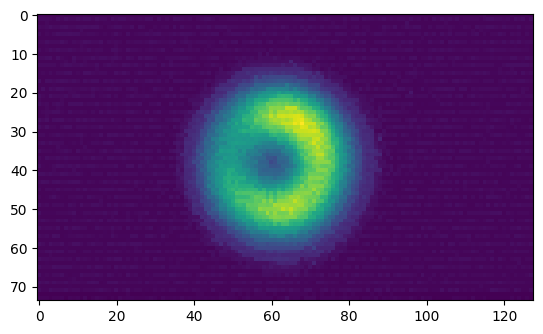

In [3]:
sum_0 = image.sum(axis=0)
sum_1 = image.sum(axis=1)
plt.imshow(image)


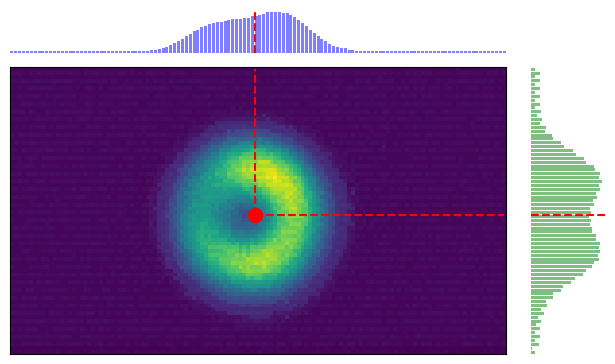

In [36]:

# Compute the sum across rows and columns
sum_0 = image.sum(axis=0)
sum_1 = image.sum(axis=1)
avg_0 = np.sum([s * i for i, s in enumerate(sum_0)]) / sum(sum_0)
avg_1 = np.sum([s * i for i, s in enumerate(sum_1)]) / sum(sum_1)

fig, ax = plt.subplots()

# Display the image
im = ax.imshow(image)

# Scatter plot for the center point
ax.scatter(avg_0, avg_1, color='red', marker='o', s=100)

# Create a bar plot for sum_0 above the image
ax_bar_x = ax.inset_axes([0, 1.05, 1, 0.15], transform=ax.transAxes)
ax_bar_x.bar(range(len(sum_0)), sum_0, color='blue', alpha=0.5)
ax_bar_x.set_xlim(ax.get_xlim())  # to align the x-axis with the image
ax_bar_x.axvline(avg_0, color='red', linestyle='--')  # vertical line for avg_0

# Create a bar plot for sum_1 to the right of the image
ax_bar_y = ax.inset_axes([1.05, 0, 0.15, 1], transform=ax.transAxes)
ax_bar_y.barh(range(len(sum_1)), sum_1, color='green', alpha=0.5)
ax_bar_y.set_ylim(ax.get_ylim())  # to align the y-axis with the image
ax_bar_y.axhline(avg_1, color='red', linestyle='--')  # horizontal line for avg_1

# Draw lines connecting the center point to the bar charts
ax.plot([avg_0, avg_0], [avg_1, 0], color='red', linestyle='--', transform=ax.transData, clip_on=False)
ax.plot([avg_0, image.shape[1]-1], [avg_1, avg_1], color='red', linestyle='--', transform=ax.transData, clip_on=False)

# Remove the spines (boxes) around the bar plots
for side in ['top', 'bottom', 'left', 'right']:
    ax_bar_x.spines[side].set_visible(False)
    ax_bar_y.spines[side].set_visible(False)

# Optional: Remove ticks to clean up the plot
ax_bar_x.set_xticks([])
ax_bar_x.set_yticks([])
ax_bar_y.set_xticks([])
ax_bar_y.set_yticks([])

ax.set_xticks([])
ax.set_yticks([])

plt.show()

C:\Users\jschulz\AppData\Local\Temp\ipykernel_10428\3038539604.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')
C:\Users\jschulz\AppData\Local\Temp\ipykernel_10428\3038539604.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


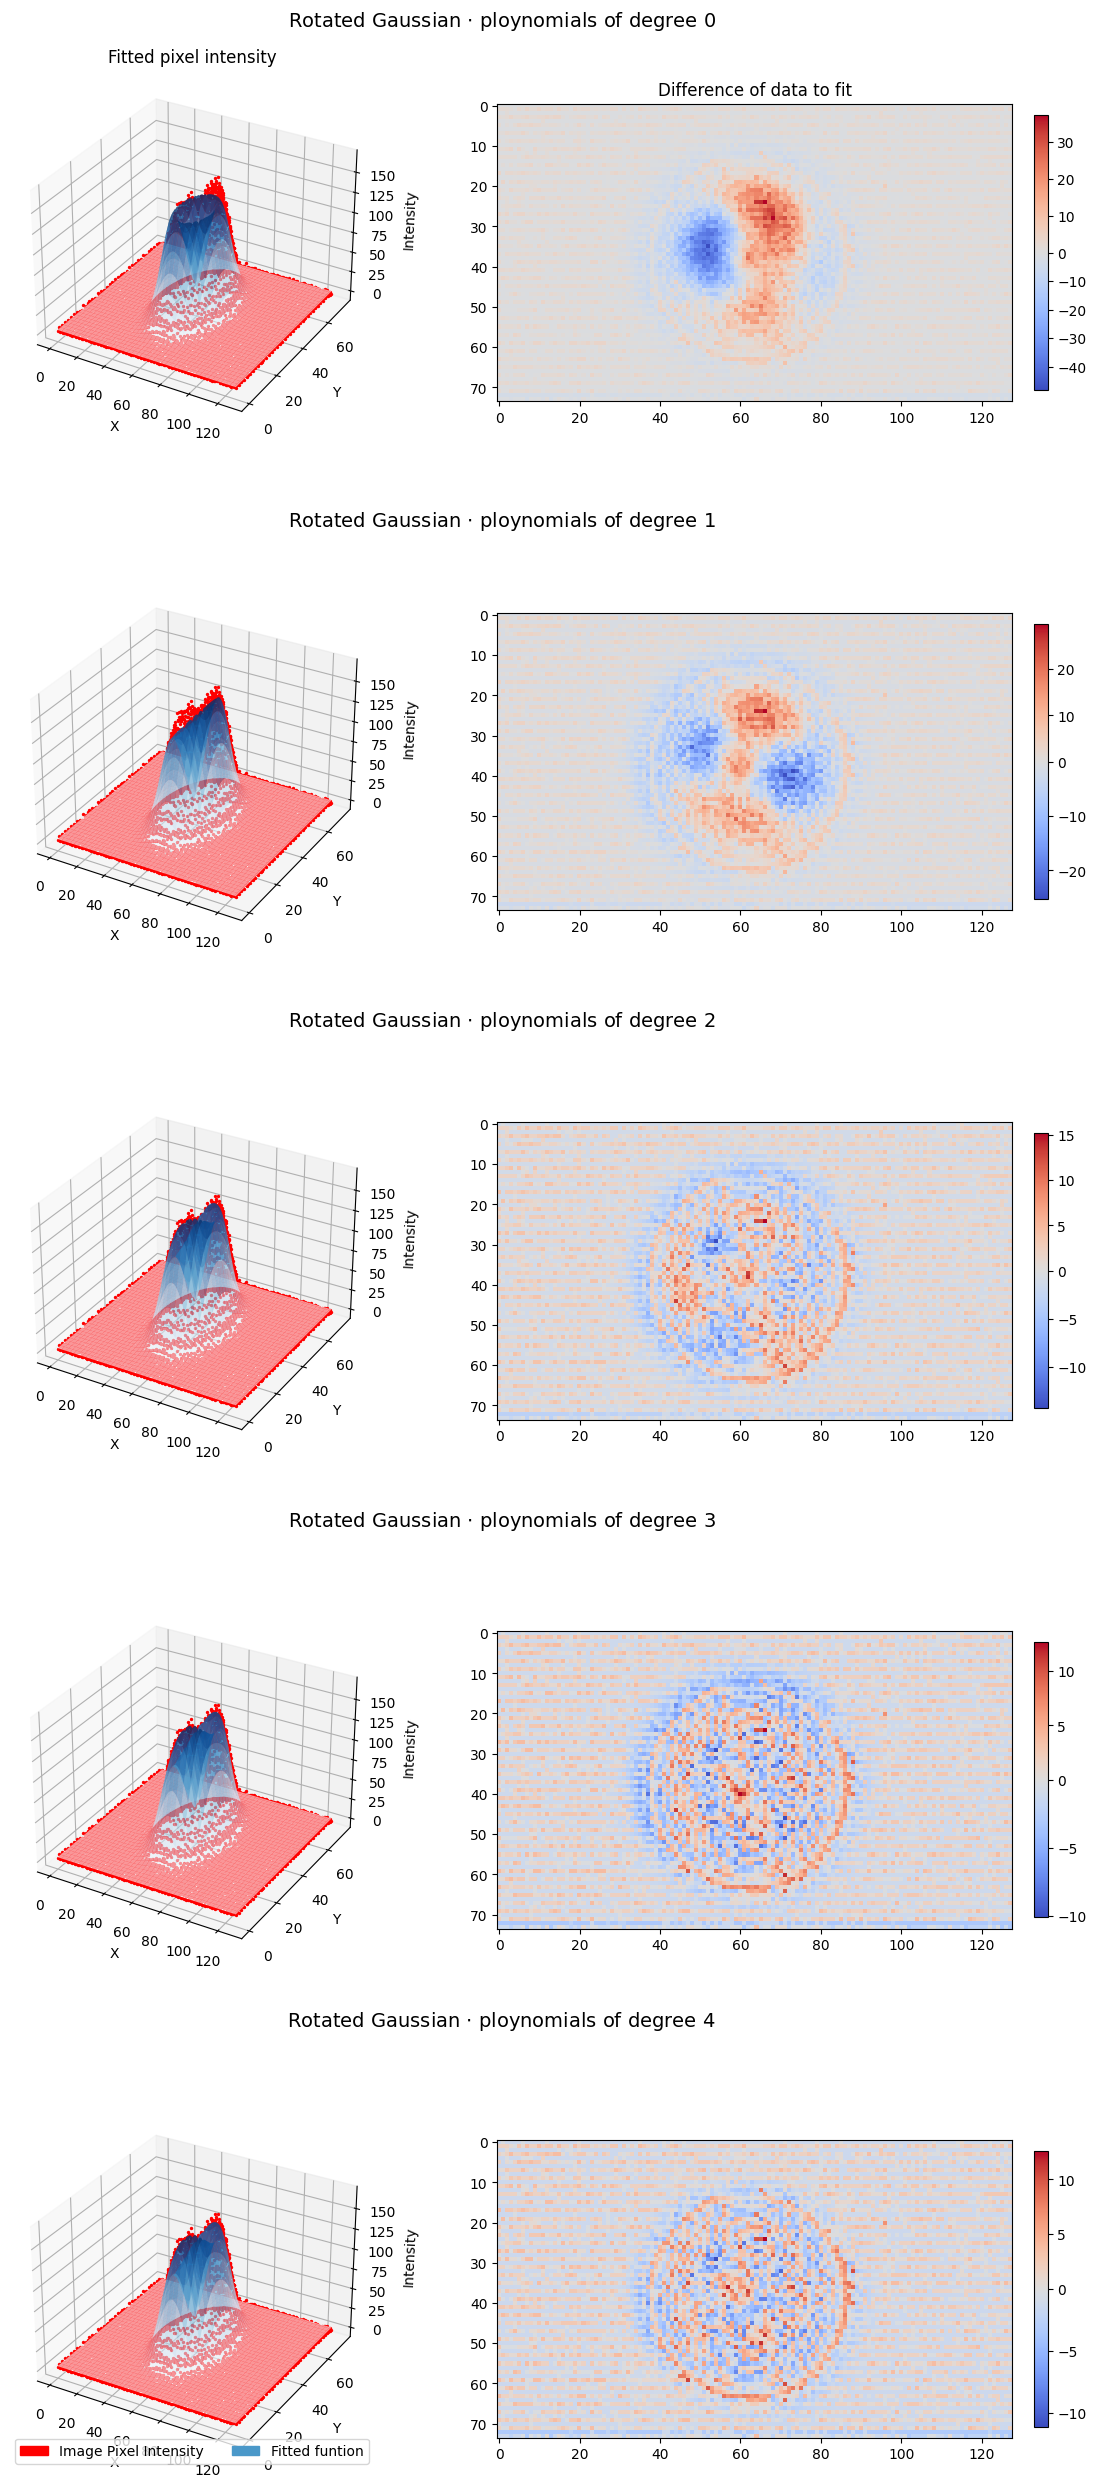

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from fast_detection_methods import gaussian_2d, fit_rotated_gaussian

from matplotlib.patches import Patch
from matplotlib import cm

def plot_3d_scatter(ax, X, Y, Z1, Z2, labels, cmap='Blues'):
    """Plot a 3D scatter plot with two datasets."""
    colormap = cm.get_cmap(cmap)
    scatter = ax.scatter(X, Y, Z1, c='red', s=2, depthshade=False, label=labels[0])
    surface = ax.plot_surface(X, Y, Z2, cmap=colormap, edgecolor='none', alpha=0.6)
    proxy1 = Patch(facecolor='red', edgecolor='red', label=labels[0])
    proxy2 = Patch(facecolor=colormap(0.6), edgecolor=colormap(0.6), label=labels[1])
    #ax.legend(handles=[proxy1, proxy2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')
    return scatter, surface



def plot_difference_heatmap(ax, image, fitted_image):
    """Plot the difference heatmap between the fitted image and the original."""
    diff = image - fitted_image
    norm = TwoSlopeNorm(vmin=min(diff.min(), -1e-5), vcenter=0, vmax=max(diff.max(), 1e-5))
    im = ax.imshow(diff, cmap='coolwarm', norm=norm)
    #ax.set_title(f'Difference between Image and Fit (degree {degree})')
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.025, pad=0.04)


def fit_and_plot(image, degree):
    """Fit an image and plot its 3D comparison and heatmap difference."""
    fit_params, _ = fit_rotated_gaussian(image, degree=degree)
    y, x = np.mgrid[:image.shape[0], :image.shape[1]]
    coords = np.vstack((x.ravel(), y.ravel()))
    fitted_image = gaussian_2d(coords, *fit_params, degree=degree).reshape(image.shape)
    return fitted_image

# Setting up the meshgrid for plotting
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

# Plotting
fig = plt.figure(figsize=(12, 5*6))  # Adjusting the size based on number of plots

degrees = range(5)  # [0, 1, 2, 3, 4, 5]

#fig.legend(handles=legend_handles, labels=['Original Image', 'Fitted Gaussian'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0))
# Create proxies for legend
proxy1 = Patch(facecolor='red', edgecolor='red', label='Image Pixel Intensity')
colormap = cm.get_cmap('Blues')
proxy2 = Patch(facecolor=colormap(0.6), edgecolor=colormap(0.6), label='Fitted funtion')

# Adjust the layout and title settings
fig_height = fig.get_figheight()  # Get the total height of the figure in inches
num_rows = len(degrees) +1 # Number of rows
row_height = fig_height / num_rows  # Height allocated for each row

for idx, degree in enumerate(degrees):
    fitted_image = fit_and_plot(image, degree)

    
    ax1 = fig.add_subplot(len(degrees), 2, idx*2 + 1, projection='3d')
    plot_3d_scatter(ax1, X, Y, image, fitted_image, ('Original Image', f'Fitted Gaussian (degree {degree})'))

    ax2 = fig.add_subplot(len(degrees), 2, idx*2 + 2)
    plot_difference_heatmap(ax2, image, fitted_image)

    if idx ==0:
        ax1.set_title('Fitted pixel intensity')
        ax2.set_title('Difference of data to fit')
    if idx == len(degrees) - 1:
        ax1.legend(handles=[proxy1, proxy2], loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0))

    # Calculate the y position for the title based on row index and row height
    title_y_position = 1 - (idx + 0.5) * row_height / fig_height  # Adjust 0.5 for centering the title

    fig.text(0.5, title_y_position, f'Rotated Gaussian $\cdot$ ploynomials of degree {degree}', ha='center', va='center', fontsize=14, transform=fig.transFigure)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.4, top=0.9)  # Adjust the top margin to ensure titles fit
#fig.legend(handles=[proxy1, proxy2], loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.1))
plt.show()



In [5]:
image_1 = numpy_movie[0]
image_2 = numpy_movie[1]
R =5
fft_convolved_image = fftconvolve(image_1, np.flip(image_2), mode='same')
peak, uncertainty = fit_gaussian(fft_convolved_image, R)

In [6]:
from detection_methods import estimate_fwhm_2d, gaussian
def produce_plot_data(data, R):
    y, x = np.indices(data.shape)
    x = x.ravel()
    y = y.ravel()
    z = data.ravel()

    # Initial guess for the parameters
    amp_guess = np.max(data)
    y0_guess, x0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_guess, _ = estimate_fwhm_2d(data)  # Assuming this function is defined elsewhere
    background_guess=0

    initial_guess = (amp_guess, x0_guess, y0_guess, sigma_guess, background_guess)

    # Create a mask for data points within a radius R around the maximum
    mask = ((x - x0_guess)**2 + (y - y0_guess)**2) <= R**2

    # Apply the mask to the data
    x_masked = x[mask]
    y_masked = y[mask]
    z_masked = z[mask]

    popt, pcov = curve_fit(gaussian, (x_masked, y_masked), z_masked, p0=initial_guess)

    # Calculate the peak position and uncertainty
    amp, x0, y0, sigma, background = popt

    #fitted_funciton = # Correct the lambda function to reshape to the correct dimensions
    fitted_function = lambda x, y: gaussian((x, y), *popt).reshape(x.shape)




    return x_masked, y_masked, z_masked, fitted_function

C:\Users\jschulz\AppData\Local\Temp\ipykernel_10428\2081823530.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


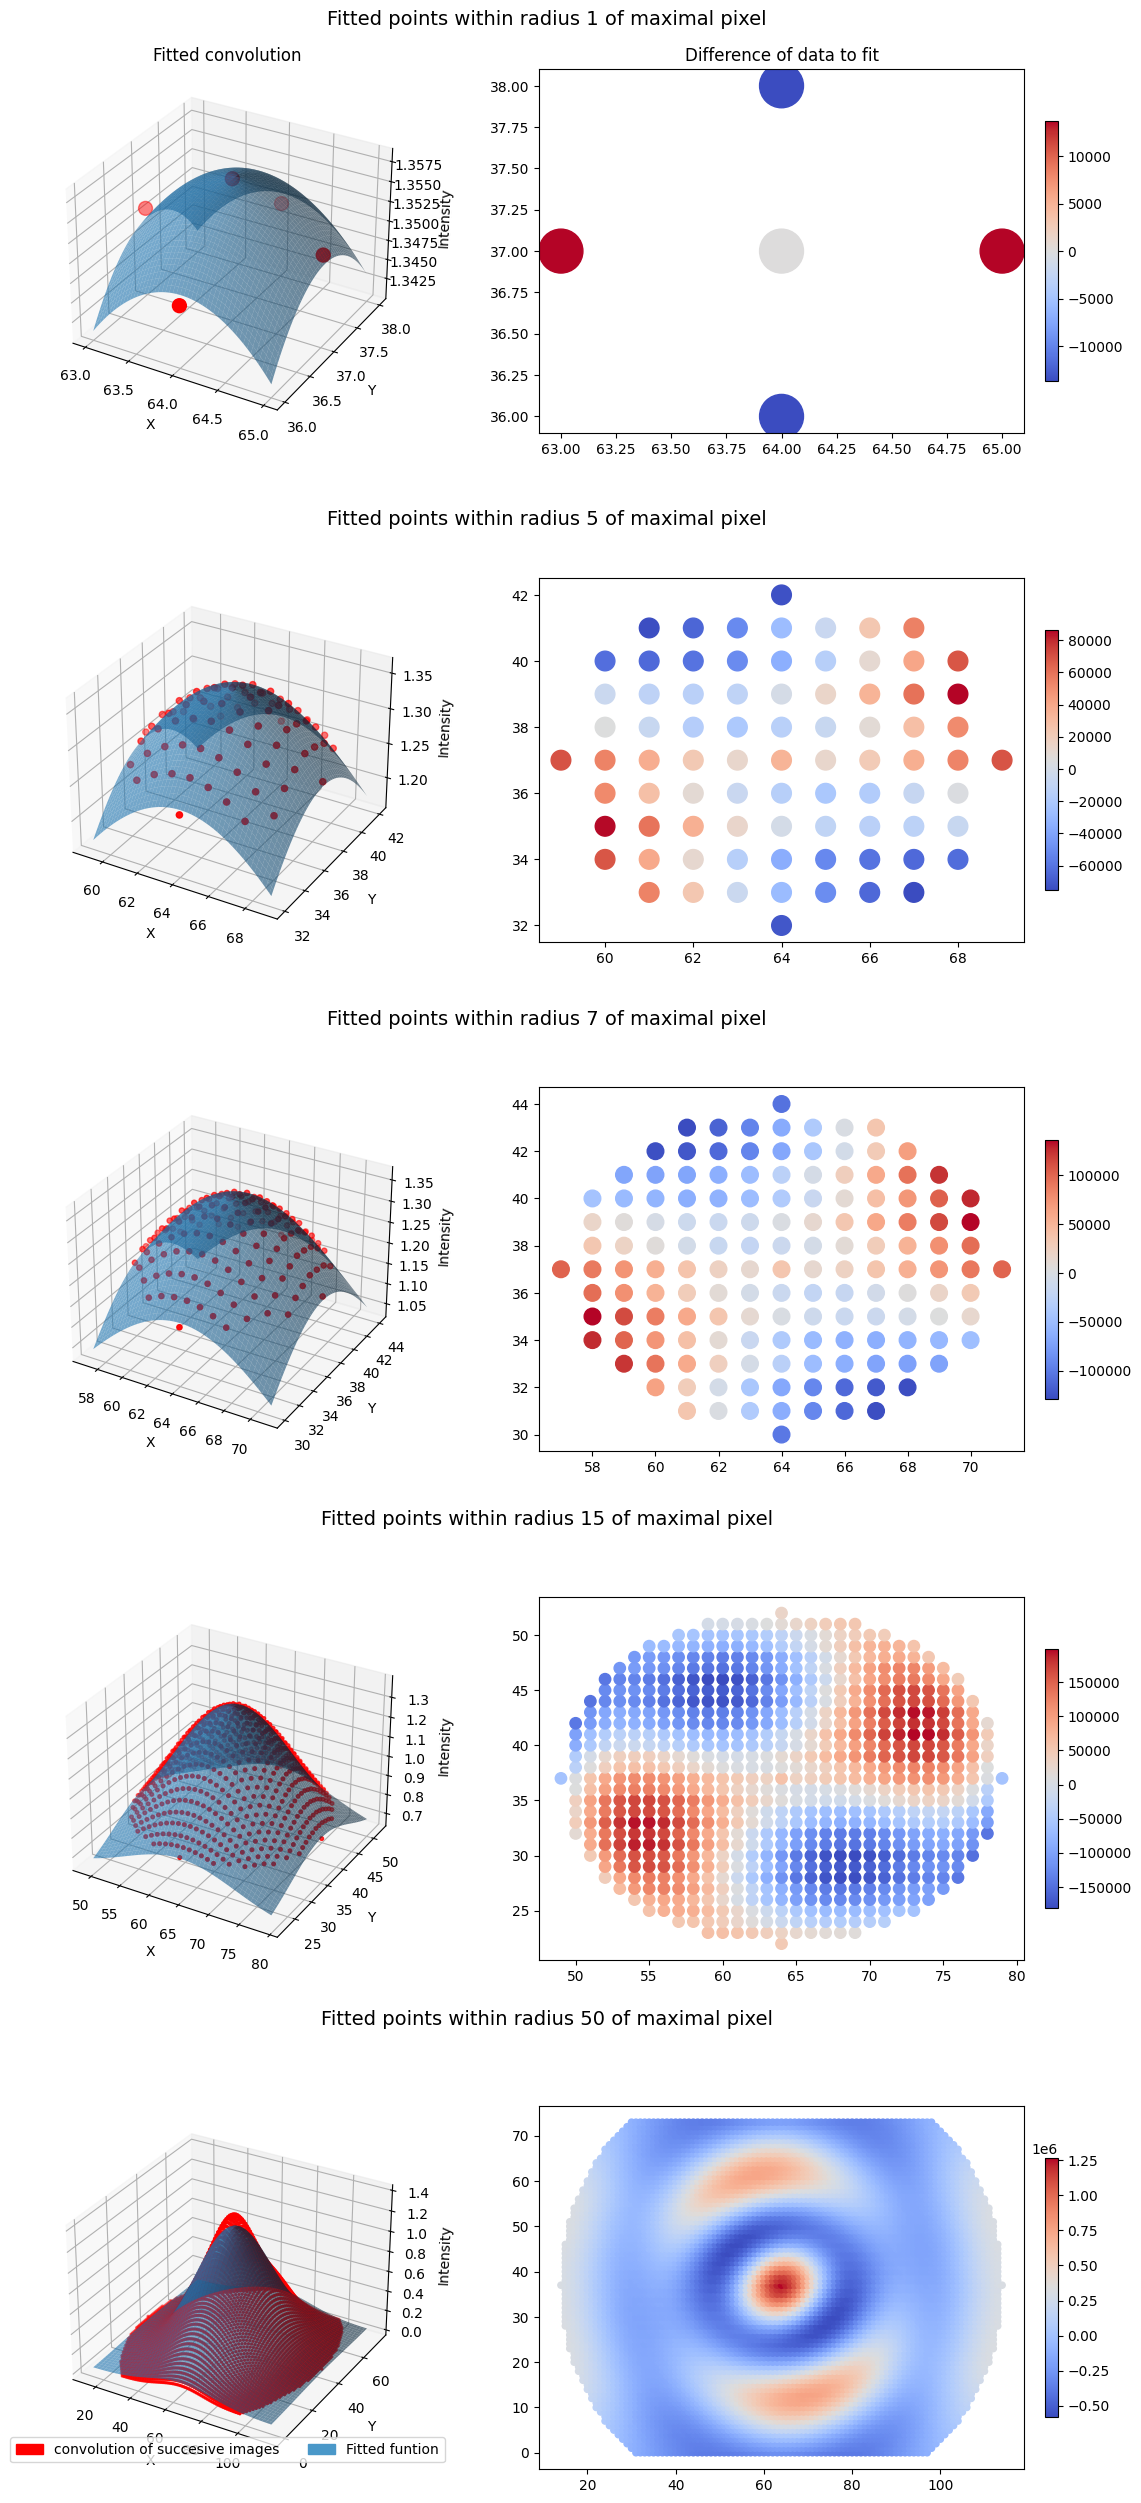

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from fast_detection_methods import gaussian_2d, fit_rotated_gaussian

from matplotlib.patches import Patch
from matplotlib import cm

def plot_3d_scatter(ax,x_masked, y_masked, z_masked, fitted_funciton):
    """Plot a 3D scatter plot with two datasets."""

    X_fine = np.linspace(x_masked.min(), x_masked.max(), 100)
    Y_fine = np.linspace(y_masked.min(), y_masked.max(), 100)

    X_fine, Y_fine = np.meshgrid(X_fine, Y_fine)
    Z_fine = fitted_funciton(X_fine, Y_fine)
    ax.scatter(x_masked, y_masked, z_masked, c='r', marker='o', s = 100/R)  # Red color, circle marker

    ax.plot_surface(X_fine, Y_fine, Z_fine, alpha=0.6)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')
    return 



def plot_difference_heatmap(ax,  x_masked, y_masked, z_masked, fitted_funciton):
    Z_fitted = fitted_funciton(x_masked, y_masked)
    diff = z_masked - Z_fitted
    # make a colorplot of the residuals
    cax = ax.scatter(x_masked, y_masked, c=diff, cmap='coolwarm', s=1000/R)
    #fig.colorbar(cax)
    norm = TwoSlopeNorm(vmin=min(diff.min(), -1e-5), vcenter=0, vmax=max(diff.max(), 1e-5))
    #im = ax.imshow(diff, cmap='coolwarm', norm=norm)
    #ax.set_title(f'Difference between Image and Fit (degree {degree})')
    fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.025, pad=0.04)




# Plotting
fig = plt.figure(figsize=(12, 5*6))  # Adjusting the size based on number of plots

R_list = [1,5,7,15,50]  # [0, 1, 2, 3, 4, 5]
#fig.legend(handles=legend_handles, labels=['Original Image', 'Fitted Gaussian'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0))
# Create proxies for legend
proxy1 = Patch(facecolor='red', edgecolor='red', label='convolution of succesive images')
colormap = cm.get_cmap('Blues')
proxy2 = Patch(facecolor=colormap(0.6), edgecolor=colormap(0.6), label='Fitted funtion')

# Adjust the layout and title settings
fig_height = fig.get_figheight()  # Get the total height of the figure in inches
num_rows = len(degrees) +1 # Number of rows
row_height = fig_height / num_rows  # Height allocated for each row

for idx, R in enumerate(R_list):
    x_masked, y_masked, z_masked, fitted_funciton = produce_plot_data(fft_convolved_image, R)

    
    ax1 = fig.add_subplot(len(degrees), 2, idx*2 + 1, projection='3d')
    plot_3d_scatter(ax1,x_masked, y_masked, z_masked, fitted_funciton)
    ax2 = fig.add_subplot(len(degrees), 2, idx*2 + 2)
    plot_difference_heatmap(ax2,  x_masked, y_masked, z_masked, fitted_funciton)

    if idx ==0:
        ax1.set_title('Fitted convolution')
        ax2.set_title('Difference of data to fit')
    if idx == len(degrees) - 1:
        ax1.legend(handles=[proxy1, proxy2], loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0))

    # Calculate the y position for the title based on row index and row height
    title_y_position = 1 - (idx + 0.5) * row_height / fig_height  # Adjust 0.5 for centering the title

    fig.text(0.5, title_y_position, f'Fitted points within radius {R} of maximal pixel', ha='center', va='center', fontsize=14, transform=fig.transFigure)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.4, top=0.9)  # Adjust the top margin to ensure titles fit
#fig.legend(handles=[proxy1, proxy2], loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.1))
plt.show()



In [80]:
z_masked

array([500220., 504742., 510335., ..., 539726., 533995., 529065.])

In [84]:
X_fine = np.linspace(x_masked.min(), x_masked.max(), 100)
Y_fine = np.linspace(y_masked.min(), y_masked.max(), 100)

X_fine, Y_fine = np.meshgrid(X_fine, Y_fine)
Z_fine = fitted_funciton(X_fine, Y_fine)

ValueError: cannot reshape array of size 10000 into shape (74,128)

In [53]:
Y.shape

(317,)

In [54]:
Z.shape

(317,)

C:\Users\jschulz\AppData\Local\Temp\ipykernel_1424\1290627113.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


Text(0, 0.5, 'Y')

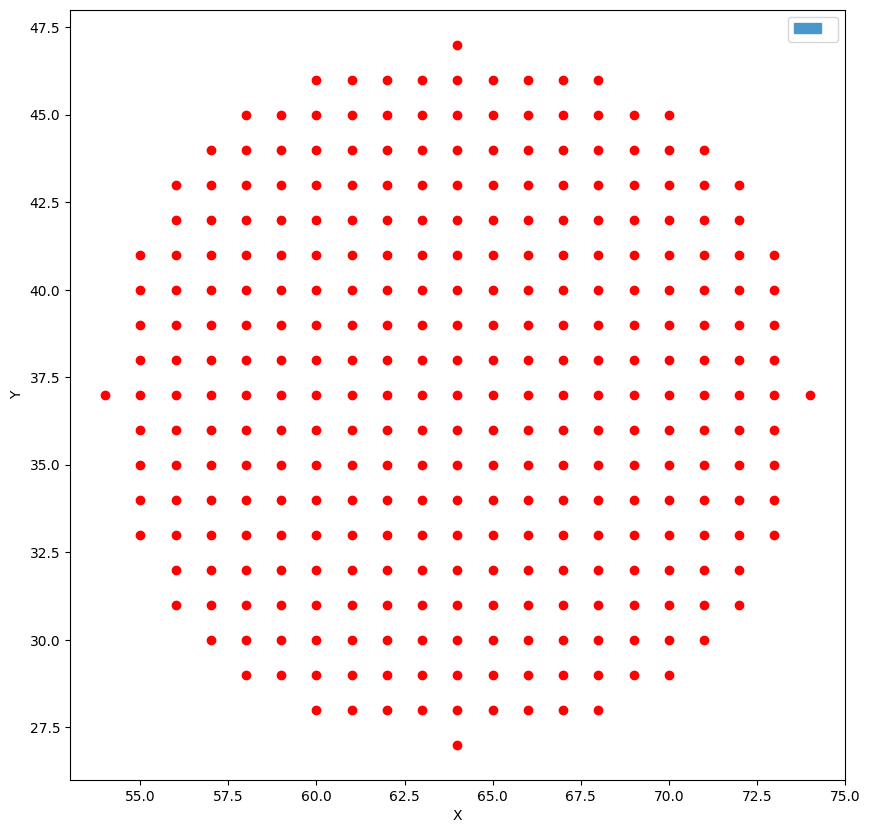

In [62]:
R = 10
X,Y,Z, fitted_image, popt = produce_plot_data(fft_convolved_image, R)

fig, ax = plt.subplots(1,1, figsize=(10, 10))

cmap = "Blues"
colormap = cm.get_cmap(cmap)
ax.scatter(X, Y, 
#ax.plot_surface(X, Y, Z2, cmap=colormap, edgecolor='none', alpha=0.6)
proxy = Patch(facecolor=colormap(0.6), edgecolor=colormap(0.6))
ax.legend(handles=[proxy])
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Intensity')


C:\Users\jschulz\AppData\Local\Temp\ipykernel_1424\1052199034.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


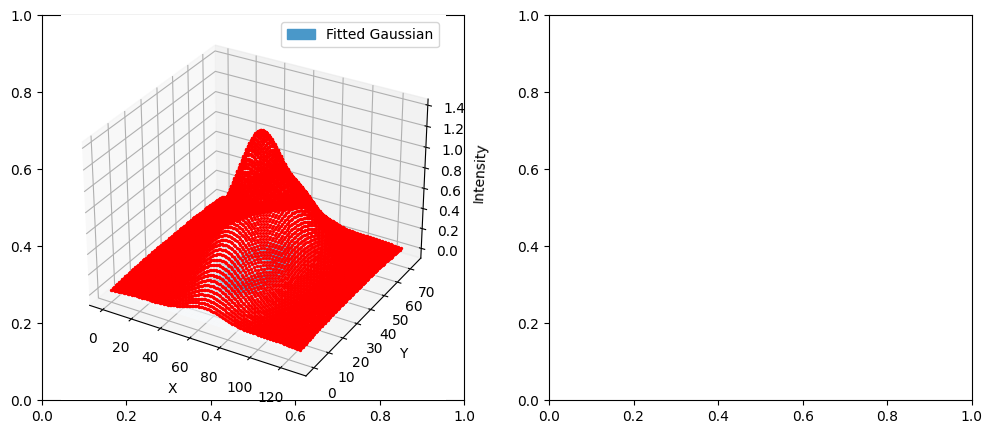

In [29]:
X, Y = np.meshgrid(np.arange(fft_convolved_image.shape[1]), np.arange(fft_convolved_image.shape[0]))
coords = np.vstack((X.ravel(), Y.ravel()))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 3D plot of the fitted image vs. the original image
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plot_3d_scatter(ax1, X, Y, fft_convolved_image, fitted_image, ('Original Image', 'Fitted Gaussian'))


In [12]:
trajectorie, movie = make_test_trajectory(image,0.01,0.1,1,500)

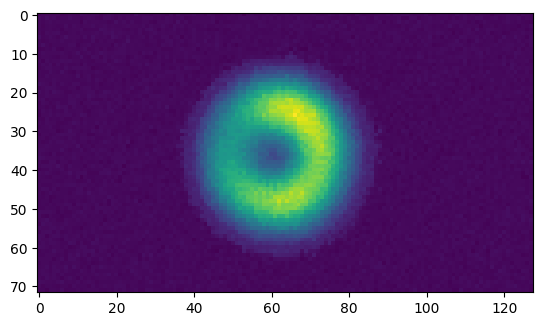

In [13]:
plt.imshow(movie[2])

In [14]:
tra_mean = trajectory_mean(movie)
tra_corr=trajectory_corr(movie)

Processing frames: 100%|██████████| 501/501 [00:00<00:00, 17459.42frame/s]
C:\Users\jschulz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Processing frames: 100%|██████████| 500/500 [00:01<00:00, 299.77frame/s]


In [15]:
degrees = range(3)  # [0, 1, 2, 3]
tra_guass_list=[]
for degree in degrees:
    tra_guass_list.append(trajectory_gauss(movie,degree =degree))

Processing every 100th frame:   0%|          | 0/6 [00:00<?, ?it/s]

Filling in frames: 100%|██████████| 500/500 [00:00<00:00, 39310.79it/s]


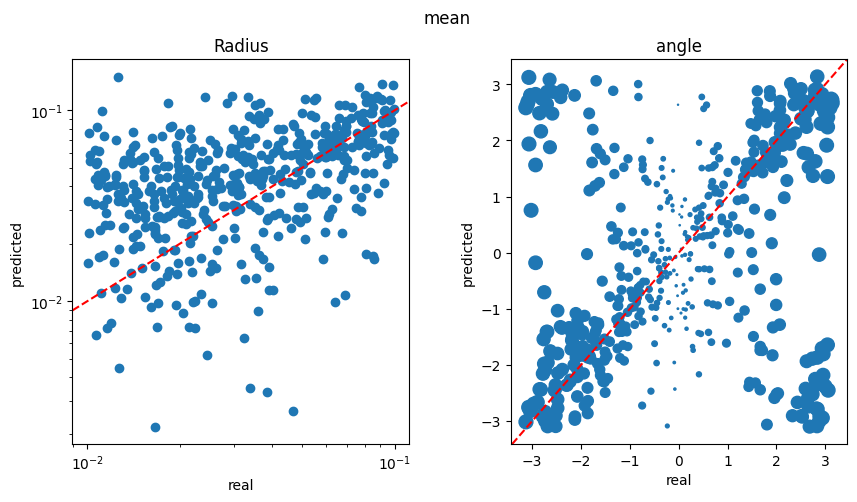

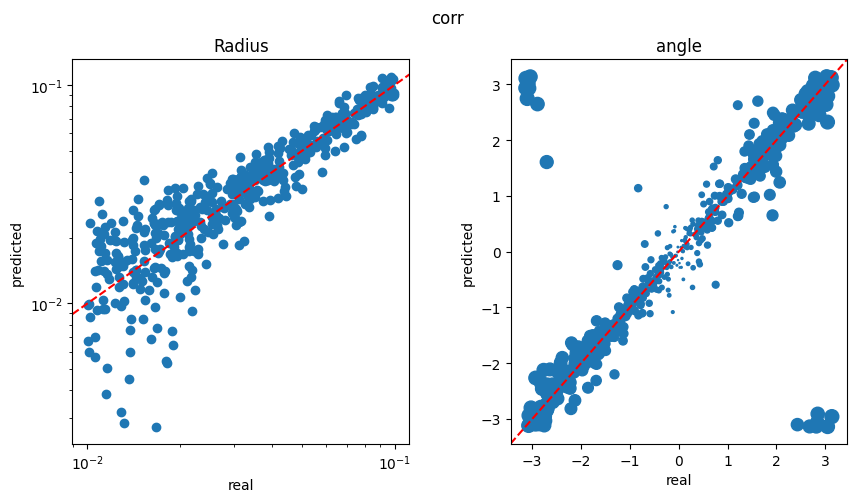

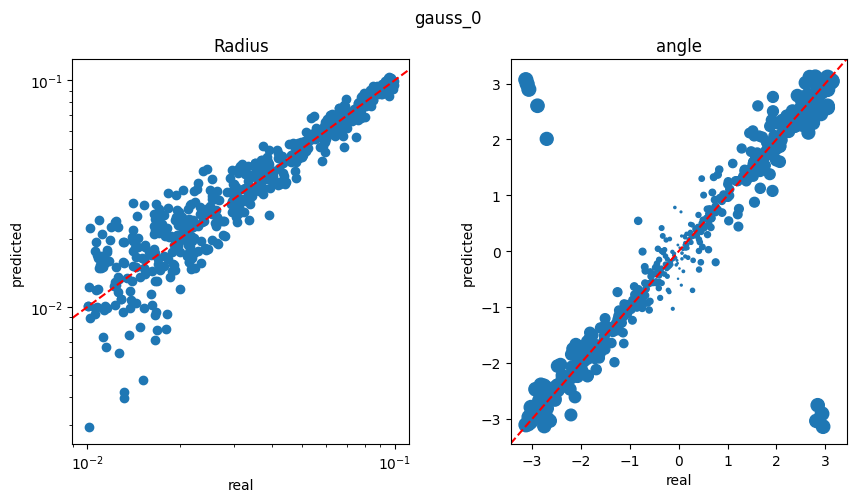

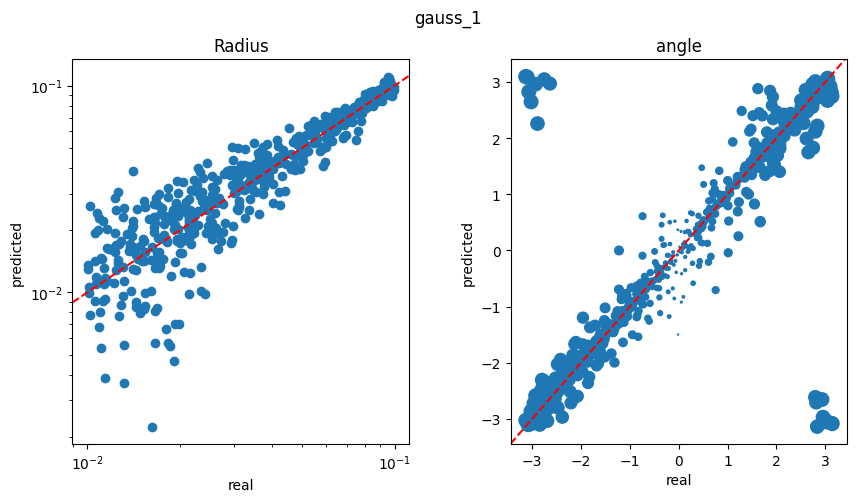

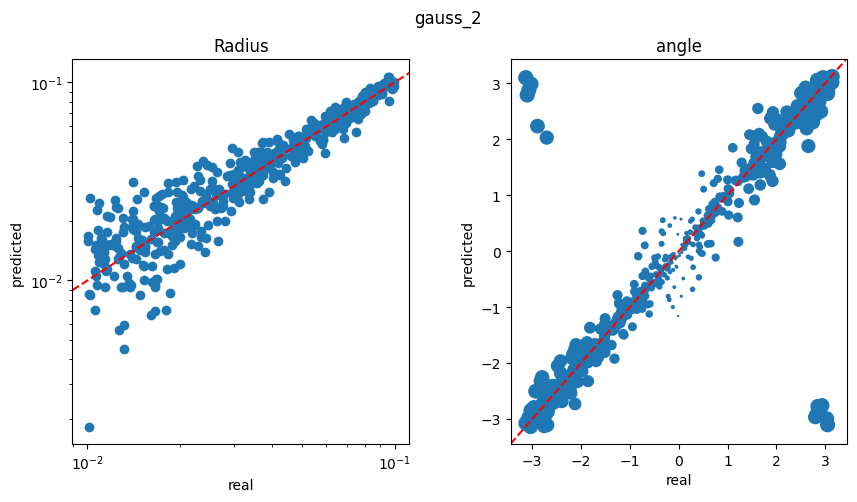

In [16]:
results_list=[]
trajectories = [tra_mean, tra_corr] + tra_guass_list
names_list=["mean","corr"] + [f"gauss_{degree}" for degree in degrees]
# Create a color list based on the viridis colormap

base_colors = ["red", "blue"]
number_of_gauss_degrees = len(degrees)
colormap = plt.cm.viridis
gauss_colors = [colormap(i) for i in np.linspace(0, 1, number_of_gauss_degrees)]

colors_list = base_colors + gauss_colors
for calc_traj , name, color in zip(trajectories, names_list, colors_list):
    Stepsize_bins, stepsize_bin_accuracies, sigma_stepsize_bin_accuracies = compare_trajectories(calc_traj, trajectorie)
    results = {
        "Stepsize_bins": Stepsize_bins,
        "stepsize_bin_accuracies": stepsize_bin_accuracies,
        "sigma_stepsize_bin_accuracies": sigma_stepsize_bin_accuracies,
        "test_traj": trajectorie,
        "calc_traj": calc_traj,
        "picture_noise": 0,

        "name": name
    }
    #plt_accuracy_results(results, name, color)
    trajectory_polar_comparison(results, name)
    results_list.append(results)

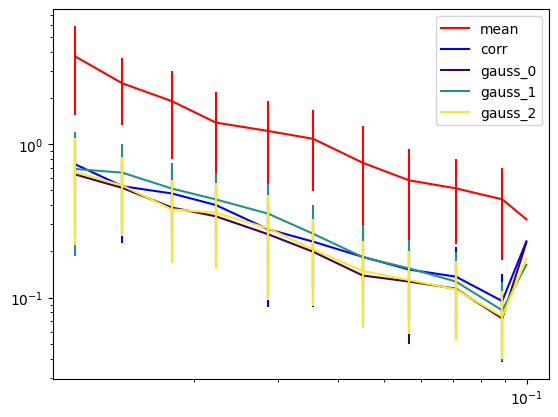

In [18]:
for result, name, color in zip(results_list, names_list, colors_list):

    plt_accuracy_results(result, name, color)
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()
#plt_accuracy_results(results_list, names_list, colors_list)